## 2. Transfer Learning

In [1]:
import warnings
warnings.filterwarnings('ignore')

import copy
import datetime
import h5py
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import sys

from cv2 import resize
from datetime import datetime
from gc import collect
from os import cpu_count
from sklearn.model_selection import train_test_split
from time import sleep
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
from tqdm import tqdm

sys.path.append(f"{os.getcwd()}/ViT architecture/Architecture tryouts/DPT/")
sys.path.append(f"{os.getcwd()}/mltfm/")
from VisionTransformer_working_for_DPT import VisionTransformer as vit
from VisionTransformer_working_for_DPT import VisionTransformer2 as vit2

2023-01-20 13:14:14.890726: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-20 13:14:15.000409: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-20 13:14:15.000426: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-20 13:14:15.024979: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-20 13:14:15.404769: W tensorflow/stream_executor/platform/de

In [2]:
random_seed = 1
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
cudnn.benchmark = True

In [3]:
collect()
torch.cuda.empty_cache()
device = torch.device('cpu')
print(f"Running on device: {device}")

Running on device: cpu


In [4]:
#from pytorch_pretrained_vit import ViT
#from VisionTransformer_working import RecTracHead, Identity, PretrainedVit
#import cv2

Modify `model_pretrained` for downstream task.

In [5]:
path_shifted = '/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/ViT architecture/Architecture tryouts/logs_and_weights/ViT_with_shifted_patch-2023-Jan-18 09:54:37/ViT_with_shifted_patch-2023-Jan-18 09:54:37.pth'

In [6]:
vit = vit(dspl_size=104,
                  patch_size=8,
                  embed_dim=128,
                  depth=12,
                  n_heads=8,
                  mlp_ratio=4.,
                  p=0.05,
                  attn_p=0.,
                  drop_path=0.).float()

vit.load_state_dict(torch.load(path_shifted)['best_model_weights'], strict=True)
vit.to(device)

VisionTransformer(
  (patch_embed): ShiftedPatchTokenization(
    (layernorm): LayerNorm((10, 104, 104), eps=1e-07, elementwise_affine=True)
    (proj): Conv2d(10, 128, kernel_size=(8, 8), stride=(8, 8))
  )
  (pos_drop): Dropout(p=0.05, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((128,), eps=1e-07, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=128, out_features=384, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=128, out_features=128, bias=True)
        (proj_drop): Dropout(p=0.05, inplace=False)
      )
      (norm2): LayerNorm((128,), eps=1e-07, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=128, out_features=512, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=512, out_features=128, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
    )
    (1): Blo

In [7]:

'''patch_tokenizer = vit_shifted.patch_embed
pos_embed = vit_shifted.pos_embed
pos_drop = vit_shifted.pos_drop
blocks = vit_shifted.blocks
norm = vit_shifted.norm
'''

'patch_tokenizer = vit_shifted.patch_embed\npos_embed = vit_shifted.pos_embed\npos_drop = vit_shifted.pos_drop\nblocks = vit_shifted.blocks\nnorm = vit_shifted.norm\n'

In [8]:
'''
path_to_2 = '/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/ViT architecture/Architecture tryouts/logs_and_weights/ViT_with_shifted_patch-2023-Jan-17 14:14:02/ViT_with_shifted_patch-2023-Jan-17 14:14:02.pth'
vit_2 = vit2(patch_tokenizer,
               pos_embed,
               pos_drop,
               blocks,
               norm,
               dspl_size=104,
               patch_size=8,
               embed_dim=128,
               depth=12,
               n_heads=8,
               mlp_ratio=4.,
               p=0.05,
               attn_p=0.,
               drop_path=0.).float()

vit_2.load_state_dict(torch.load(path_to_2)['best_model_weights'], strict=True)
vit_2.to(device)
'''

"\npath_to_2 = '/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/ViT architecture/Architecture tryouts/logs_and_weights/ViT_with_shifted_patch-2023-Jan-17 14:14:02/ViT_with_shifted_patch-2023-Jan-17 14:14:02.pth'\nvit_2 = vit2(patch_tokenizer,\n               pos_embed,\n               pos_drop,\n               blocks,\n               norm,\n               dspl_size=104,\n               patch_size=8,\n               embed_dim=128,\n               depth=12,\n               n_heads=8,\n               mlp_ratio=4.,\n               p=0.05,\n               attn_p=0.,\n               drop_path=0.).float()\n\nvit_2.load_state_dict(torch.load(path_to_2)['best_model_weights'], strict=True)\nvit_2.to(device)\n"

In [9]:
cnn = keras.models.load_model('/home/alexrichard/PycharmProjects/UQ_DL-TFM/mltfm/models/model_noise_1e-4.h5')

2023-01-20 13:14:19.520399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-20 13:14:19.522141: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/alexrichard/.local/lib/python3.8/site-packages/cv2/../../lib64:
2023-01-20 13:14:19.522181: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusparse.so.11'; dlerror: libcusparse.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/alexrichard/.local/lib/python3.8/site-packages/cv2/../../lib64:
2023-01-20 13:14:19.522225: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the miss

In [10]:
dspl = h5py.File('data/Test data/resolution_104/allDisplacements')["dspl"]
trac = h5py.File('data/Test data/resolution_104/allTractions')["trac"]

dspl = np.moveaxis(np.concatenate([dspl[i] for i in range(dspl.shape[0])], axis=0), 3, 1)
trac_separated = np.moveaxis(np.concatenate([trac[i] for i in range(trac.shape[0])], axis=0), 3, 1)

X_test = torch.from_numpy(dspl).double().to(device)
Y_test = torch.from_numpy(trac_separated).double().to(device)

cov = [[1e-04 ** 2, 0], [0, 1e-04 ** 2]]

X_test_noise = np.transpose(np.random.multivariate_normal(np.array([0, 0]), cov, (X_test.shape[0], X_test.shape[2], X_test.shape[3])), (0, 3, 2, 1))
X_test_noise = X_test + X_test_noise

In [11]:
vit.eval()
#vit_2.eval()
#pred_vit_2 = vit_2(X_test_noise.float(), device=device)
pred_vit = vit(X_test_noise.float(), device=device)
pred_cnn = cnn.predict(np.moveaxis(np.array(X_test_noise), 1, 3))

4/4 [==============================] - 0s 36ms/step


In [12]:
mse = torch.nn.MSELoss(reduction='none')
#mse_vit2 = torch.mean(mse(pred_vit_2, Y_test[:, 0:2]), (1, 2, 3))
mse_vit = torch.mean(mse(pred_vit, Y_test[:, 0:2]), (1, 2, 3))
mse_cnn = torch.mean(mse(torch.tensor(np.moveaxis(pred_cnn, 3, 1)), Y_test[:, 0:2]), (1, 2, 3))

<IPython.core.display.Javascript object>


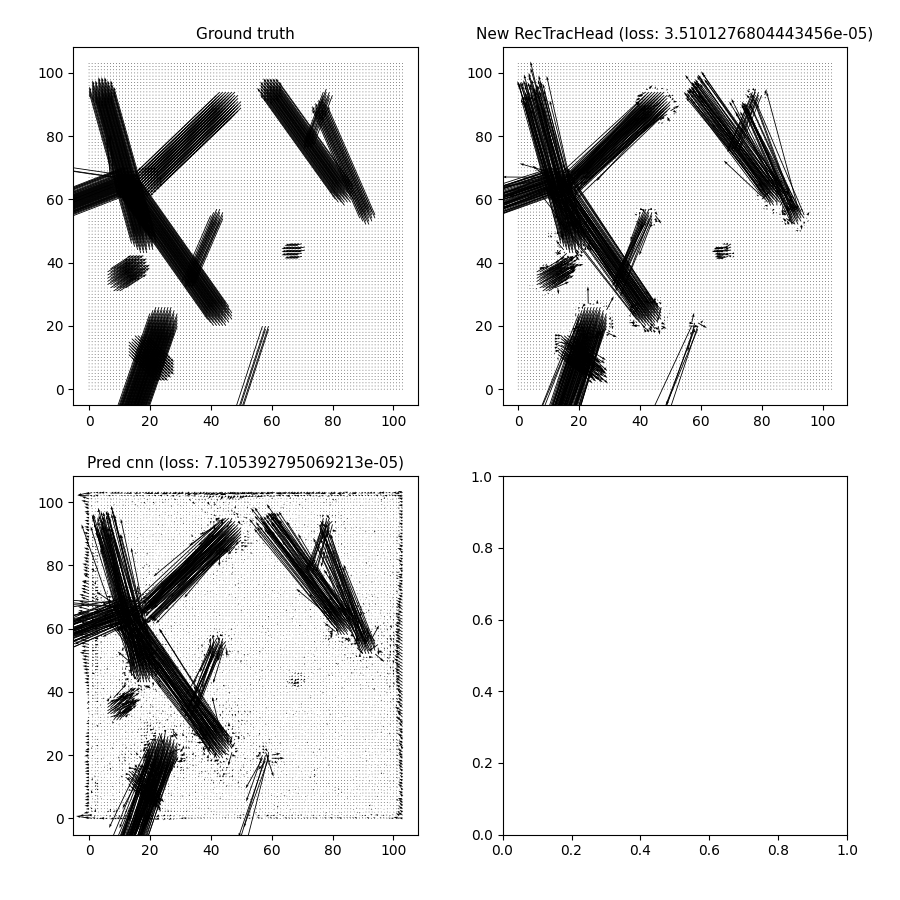

Text(0.5, 1.0, 'Pred cnn (loss: 7.105392795069213e-05)')

In [13]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(2, 2, figsize=(9, 9))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0, 0].quiver(trac_separated[0, 0, :, :], trac_separated[0, 1, :, :], scale=1)
axs[0, 0].set_title('Ground truth', {'fontsize': 11})

axs[0, 1].quiver(pred_vit[0, 0, :, :].detach().numpy(), pred_vit[0, 1, :, :].detach().numpy(), scale=1)
axs[0, 1].set_title(f'New RecTracHead (loss: {mse_vit[0]})', {'fontsize': 11})

#axs[1, 0].quiver(pred_shifted_vit[0, 0, :, :].detach().numpy(), pred_shifted_vit[0, 1, :, :].detach().numpy(), scale=1)
#axs[1, 0].set_title(f'Pred shifted vit (loss: {mse_shifted_vit[0]})', {'fontsize': 11})

axs[1, 0].quiver(pred_cnn[0, :, :, 0], pred_cnn[0, :, :, 1], scale=1)
axs[1, 0].set_title(f'Pred cnn (loss: {mse_cnn[5]})', {'fontsize': 11})

Deep dive into the models intermediate output to detect where 'patch-structure' of the prediction occurs.

In [14]:
vit_shifted.eval()
logits, attn_scores, x = vit_shifted(X_test[0:2, :, :, :].float(), device=device, return_attention=True)

NameError: name 'vit_shifted' is not defined

In [ ]:
logits.shape

In [ ]:
len(attn_scores)

In [ ]:
attn_scores[11].shape

In [ ]:
x.shape

In [ ]:
x_1 = x.transpose(1, 2)[0]

In [ ]:
x_1.shape

In [ ]:
x_1 = x_1.unflatten(1, (13, 13))

In [ ]:
patch = x_1[:, 12, 6].reshape((2, 8, 8))

In [ ]:
patch.shape

In [ ]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(1, 2, figsize=(6, 6))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0].quiver(pred_shifted_vit[0, 0, :, :].detach().numpy(), pred_shifted_vit[0, 1, :, :].detach().numpy(), scale=1)
axs[0].set_title('logits', {'fontsize': 11})

axs[1].quiver(pred_vit_2[0, 0, :, :].detach().numpy(), pred_vit_2[0, 1, :, :].detach().numpy(), scale=1)
axs[1].set_title(f'New RecTracHead (loss: {mse_vit2[0]})', {'fontsize': 11})

In [ ]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(1, 1, figsize=(9, 9))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs.imshow(attn_scores[11][0, 0, :, :].detach().numpy())
axs.set_title('atttention', {'fontsize': 11})

Segmentation network.

In [ ]:
path_segment = '/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/Transfer learning/logs_and_weights/ViT_segmentation-2023-Jan-15 14:27:55/ViT_segmentation-2023-Jan-15 14:27:55.pth'

In [ ]:
vit_segment = vit_old(dspl_size=104,
                      patch_size=8,
                      embed_dim=128,
                      depth=12,
                      n_heads=8,
                      mlp_ratio=4.,
                      p=0.05,
                      attn_p=0.,
                      drop_path=0.).float()

In [ ]:
vit_segment.load_state_dict(torch.load(path_segment)['final_model_weights'], strict=True)
vit_segment.to(device)

In [ ]:
os.getcwd()

In [ ]:
checko = torch.load(f'ViT architecture/Architecture tryouts/logs_and_weights/ViT_with_shifted_patch-2023-Jan-15 22:08:39/ViT_with_shifted_patch-2023-Jan-15 22:08:39.pth')

In [ ]:
checko['best_model_weights'].rec_trac_head

In [ ]:
pred_segment_vit = vit_segment(X_test.float())

In [ ]:
loss = torch.nn.BCEWithLogitsLoss()
Y = torch.where(Y_test[:, 2:] > 0, 1, 0)
loss_segment = loss(pred_segment_vit, Y.float())

In [ ]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(1, 2, figsize=(5, 9))
fig.tight_layout(pad=1, w_pad=1, h_pad=1)

axs[0].imshow(torch.round(torch.sigmoid(pred_segment_vit[0, 0, :, :])).detach().numpy())
axs[0].set_title('Input', {'fontsize': 11})

axs[1].imshow(Y[0, 0, :, :].detach().numpy())
axs[1].set_title('Ground truth', {'fontsize': 11})

In [ ]:
torch.round(torch.sigmoid(pred_segment_vit[0, 0, :, :]))

In [ ]:
def crop_shif_pad(x, mode):
    half_patch_size = (104 // 8) // 2
    padded_x = torch.zeros(size=(x.shape))
    n_samples, c, h, w = x.shape
    if mode == 'left-up':
        padded_x[:, :, 0:h-half_patch_size:, half_patch_size:] = x[:, :, half_patch_size:, 0:w-half_patch_size]
    if mode == 'right-up':
        padded_x[:, :, 0:h-half_patch_size, 0:w-half_patch_size] = x[:, :, half_patch_size:, half_patch_size:]
    if mode == 'left-down':
        padded_x[:, :, half_patch_size:, half_patch_size:] = x[:, :, 0:h-half_patch_size:, 0:w-half_patch_size]
    if mode == 'right-down':
        padded_x[:, :, half_patch_size:, 0:w-half_patch_size] = x[:, :, 0:h-half_patch_size:, half_patch_size:]

    return padded_x

In [ ]:
X_test_leftup = crop_shif_pad(X_test, mode='left-up')
X_test_rightup = crop_shif_pad(X_test, mode='right-up')
X_test_leftdown = crop_shif_pad(X_test, mode='left-down')
X_test_rightdown = crop_shif_pad(X_test, mode='right-down')

In [ ]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(2, 2, figsize=(9, 9))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0, 0].quiver(X_test_leftup[0, 0, :, :].detach().numpy(), X_test_leftup[0, 1, :, :].detach().numpy(), scale=1)
axs[0, 0].set_title('Input', {'fontsize': 11})

axs[0, 1].quiver(X_test_rightup[0, 0, :, :].detach().numpy(), X_test_rightup[0, 1, :, :].detach().numpy(), scale=1)
axs[0, 1].set_title('Ground truth', {'fontsize': 11})

axs[1, 0].quiver(X_test_leftdown[0, 0, :, :].detach().numpy(), X_test_leftdown[0, 1, :, :].detach().numpy(), scale=1)

axs[1, 1].quiver(X_test_rightdown[0, 0, :, :].detach().numpy(), X_test_rightdown[0, 1, :, :].detach().numpy(), scale=1)


In [ ]:
concat = torch.cat((X_test, X_test_leftup, X_test_rightup, X_test_leftdown, X_test_rightdown), axis=1)

In [ ]:
X_test.shape

In [ ]:
concat.shape

In [ ]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(2, 2, figsize=(9, 9))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0, 0].quiver(concat[0, 0, :, :].detach().numpy(), concat[0, 1, :, :].detach().numpy(), scale=1)
axs[0, 0].set_title('Input', {'fontsize': 11})

axs[0, 1].quiver(concat[0, 2, :, :].detach().numpy(), concat[0, 3, :, :].detach().numpy(), scale=1)
axs[0, 1].set_title('Ground truth', {'fontsize': 11})

axs[1, 0].quiver(concat[0, 4, :, :].detach().numpy(), concat[0, 5, :, :].detach().numpy(), scale=1)

axs[1, 1].quiver(concat[0, 6, :, :].detach().numpy(), concat[0, 7, :, :].detach().numpy(), scale=1)
